In [3]:
import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np   
import pandas as pd
import scipy.constants as con

import arc as arc

In [4]:
#define atom for ARC
atom = arc.Strontium88()

OperationalError: database is locked

This is to caliculate the 87Sr energy structure including higpower fine structure. I will try to reproduce the calculation in Ding 2018 (https://arxiv.org/pdf/1808.05987.pdf). Arc is used for the $^{88}$Sr data.

In [ ]:
I = 9/2 #nuclear spin
a = -4.156e-6 #highpower fine coupling constant[eV] corresponding to 1GHz

m_Sr88 = 87.905619*con.au #mass of 88Sr [kg] from NIST database
m_Sr87 = 86.908884*con.au #mass of 87Sr [kg] from NIST database

#electron reduced mass 
#(this would not be rigolas. to make it rigolas I should use ion mass?)
m88 = con.m_e*(m_Sr88-con.m_e)/m_Sr88
m87 = con.m_e*(m_Sr87-con.m_e)/m_Sr87

E0Sr = 5.69485607 #eV (from NIST database ionization energy :45932.09 cm^-1)

Rinf = con.physical_constants['Rydberg constant times hc in eV'][0]

# Import $^{88}$Sr isotope quantum defect data from ARC 

ARC provides experimentally determined quantum defect data for $^{88}$Sr using multiple references. (https://arc-alkali-rydberg-calculator.readthedocs.io/en/latest/_modules/arc/divalent_atom_data.html#Strontium88.getPressure)

In [99]:
N=np.arange(10,100,1)

#quantum defect data import for 88Sr
Sr1S0_qd = atom.getQuantumDefect(N,l=0,j=0,s=0)
Sr3S1_qd = atom.getQuantumDefect(N,l=0,j=1,s=1)

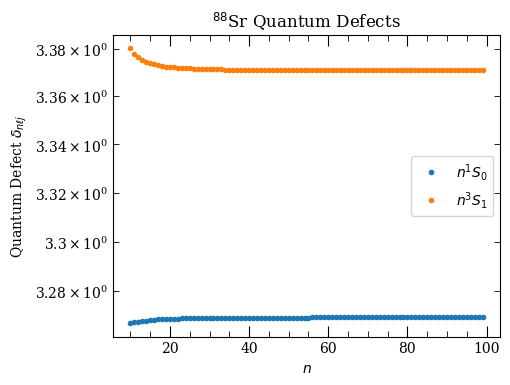

In [100]:
#plot
fig, axes = plt.subplots(1, 1, figsize=(5,4), dpi=100)

axes.semilogy(N,Sr1S0_qd,'.',label="$n{}^1S_{0}$")
axes.semilogy(N,Sr3S1_qd,'.',label="$n{}^3S_{1}$")
axes.legend(loc=0)
axes.set_xlabel('$n$')
axes.set_ylabel('Quantum Defect $\delta_{n\ell j}$')
axes.set_title('$^{88}$Sr Quantum Defects')

plt.show()

using this, calculate the level structure (based on ARC's source code)

In [133]:
Sr1S0_energy = []
#Sr1S0_energy_arc = []
for i in range(len(N)):
    Sr1S0_energy.append(-(m88/con.m_e)*Rinf / ((N[i] - Sr1S0_qd[i])**2))
    #Sr1S0_energy_arc.append(atom.getEnergy(N[i],l=0,j=0,s=0))

Sr3S1_energy = []
#Sr3S1_energy_arc = []
for i in range(len(N)):
    Sr3S1_energy.append(-(m88/con.m_e)*Rinf / ((N[i] - Sr3S1_qd[i])**2))
    #Sr3S1_energy_arc.append(atom.getEnergy(N[i],l=0,j=1,s=1))

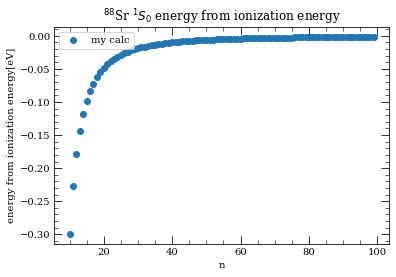

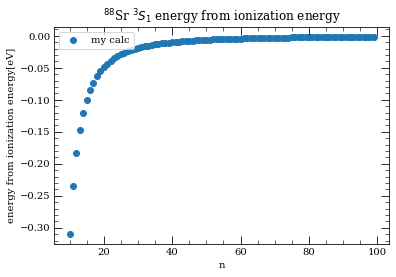

In [135]:
plt.scatter(N,Sr1S0_energy, label= 'my calc')
#plt.scatter(N,Sr1S0_energy_arc,label = 'arc')
plt.legend()
plt.title('$^{88}$Sr $^1S_0$ energy from ionization energy')
plt.xlabel('n')
plt.ylabel('energy from ionization energy[eV]')
plt.show()

plt.scatter(N,Sr3S1_energy, label= 'my calc')
#plt.scatter(N,Sr3S1_energy_arc,label = 'arc')
plt.legend()
plt.title('$^{88}$Sr $^3S_1$ energy from ionization energy')
plt.xlabel('n')
plt.ylabel('energy from ionization energy[eV]')
plt.show()

# Convert $^{88}$Sr level to $^{87}$Sr $I=0$ energy level

I know there are no such atom but this is used as a initial hamiltonian, H_0(88,m87) in the reference

In [103]:
Sr1S0_energy = np.array(Sr1S0_energy)
Sr3S1_energy = np.array(Sr3S1_energy)

#rescale reduced mass, adding ionization energy [eV]
Sr1S0_Energy_87 = E0Sr + m87/m88*Sr1S0_energy
Sr3S1_Energy_87 = E0Sr + m87/m88*Sr3S1_energy

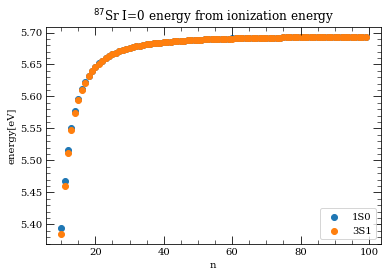

In [104]:
plt.scatter(N,Sr1S0_Energy_87, label= '1S0')
plt.scatter(N,Sr3S1_Energy_87,label = '3S1')
plt.legend()
plt.title('$^{87}$Sr I=0 energy from ionization energy')
plt.xlabel('n')
plt.ylabel('energy[eV]')
plt.show()

# Hamiltonian and diagonalization (ignoring intra n coupling)

The hyperfine interaction matrix element between different n is small in the reference method.(eq. 12) I will first do the diagonalization neglecting this intra n coupling.

The basis order is
|1S0F=9/2>,|3S1F=9/2>

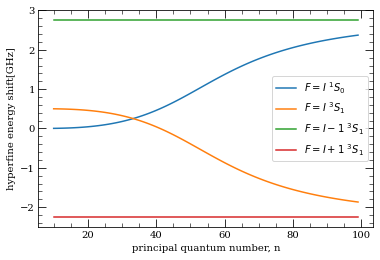

In [224]:
E87 = []

for i in range(len(N)):
    H = np.zeros((2,2))
    H[0,0] = Sr1S0_Energy_87[i] #1S0 F_9/2
    H[1,1] = Sr3S1_Energy_87[i] - 1/2*a #3S1 F_9/2
    H[0,1] = H[1,0] = 1/2*a*np.sqrt(I*(I+1))
    
    w, v = np.linalg.eig(H)
    E87.append(w)
Id = np.full(np.shape(N),1)   
E87 = np.array(E87)
plt.plot(N,(E87[:,0] - Sr1S0_Energy_87)*241799,label='$F=I ~^1S_0$') #converting eV to GHz
plt.plot(N,(E87[:,1] - Sr3S1_Energy_87)*241799,label='$F=I ~^3S_1$')
plt.plot(N,(- 1/2*a*(I+1))*Id*241799,label='$F=I-1 ~^3S_1$')
plt.plot(N,( + 1/2*a*I)*Id*241799,label='$F=I+1 ~^3S_1$')
plt.legend()
plt.xlabel('principal quantum number, n')
plt.ylabel('hyperfine energy shift[GHz]')

plt.show()

# Hamiltonian and diagonalization (including intra n coupling)

I will not ignore the intra n coupling this time.

The basis order is
....,|n 1S0F=9/2>,|n 3S1F=9/2>,|n+1 1S0F=9/2>,|n+1 3S1F=9/2>,....

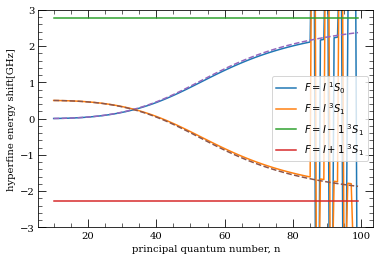

In [238]:
H = np.zeros((2*len(N),2*len(N)))
for i in range(len(N)):
    H[2*i,2*i] = Sr1S0_Energy_87[i]*241799
    H[2*i+1,2*i+1] = (Sr3S1_Energy_87[i] - 1/2*a)*241799 #GHz
    H[2*i,2*i+1] = H[2*i+1,2*i] = 1/2*a*np.sqrt(I*(I+1))*0.98*241799
    if i != 0:
        H[2*(i-1),2*i+1] = H[2*(i-1)+1,2*i] = H[2*i,2*(i-1)+1] = H[2*i+1,2*(i-1)] = 1/2*a*np.sqrt(I*(I+1))*0.1*241799

W, V = np.linalg.eig(H)
EnergyFI1S0 = np.zeros(len(N))
EnergyFI3S1 = np.zeros(len(N))
for j in range(2*len(N)):
    index = np.abs(V[j]).argmax()
    if index%2 == 0:
        EnergyFI1S0[index//2]=W[j]

    else:
        EnergyFI3S1[index//2]=W[j]


Id = np.full(np.shape(N),1)   


plt.plot(N,EnergyFI1S0-Sr1S0_Energy_87*241799,label='$F=I ~^1S_0$') #converting eV to GHz
plt.plot(N,EnergyFI3S1-Sr3S1_Energy_87*241799,label='$F=I ~^3S_1$')
plt.plot(N,(- 1/2*a*(I+1))*Id*241799,label='$F=I-1 ~^3S_1$')
plt.plot(N,( + 1/2*a*I)*Id*241799,label='$F=I+1 ~^3S_1$')
plt.legend()
plt.xlabel('principal quantum number, n')
plt.ylabel('hyperfine energy shift[GHz]')
plt.ylim(-3,3)

plt.plot(N,(E87[:,0] - Sr1S0_Energy_87)*241799,'--',label='ignoring intra n coupling $F=I ~^1S_0$') #converting eV to GHz
plt.plot(N,(E87[:,1] - Sr3S1_Energy_87)*241799,'--',label='ignoring intra n coupling $F=I ~^3S_1$')


plt.show()

In [216]:
A=np.arange(0,100,2)
print(A)
A.argmax()

[ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94
 96 98]


49